### Using UCC on FakeTorino


In [1]:
from qiskit import QuantumCircuit
from qiskit import transpile as qiskit_transpile
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_aer import AerSimulator

In [2]:
%matplotlib inline

In [3]:
# 1. Initialize the fake backend
fake_backend = FakeTorino()

In [4]:
# 2. Create a quantum circuit
def bell_state_circuit(num_qubits=2):
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    return qc

In [5]:
import ucc

def run_circuit(qc, simulator, compiler_name, shots=5000):
    if compiler_name == 'ucc':
        compiled_qc = ucc.compile(qc, target_device=fake_backend.target)
    elif compiler_name == 'qiskit':
        compiled_qc = qiskit_transpile(qc, fake_backend)
    
    # 5. Run the compiled circuit on the simulator
    job = simulator.run(compiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts(compiled_qc)
    
    # 6. Print the results
    print(
        f"Counts from noisy simulation on FakeTorino with {compiler_name}: {counts}"
    )

    return (compiler_name, counts)

/Users/jordansullivan/UnitaryFund/research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qbraid/_entrypoints.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
# 3. Create an AerSimulator with the noise model of the fake backend
# This allows for noisy simulation mimicking the real hardware.
simulator = AerSimulator.from_backend(fake_backend)

results = []
qc = bell_state_circuit(10)

# 4. Compile and simulate with UCC
results.append(run_circuit(qc, simulator, 'ucc', 10000))

# 5. Compile and simulate with Qiskit
qc = bell_state_circuit(10)
results.append(run_circuit(qc, simulator, 'qiskit', 10000))

/Users/jordansullivan/UnitaryFund/research/ucc-hw-aware/.venv/lib/python3.13/site-packages/ucc/compile.py:73: UserWarning: Warning: The target gateset None is not supported by the target device. 
  warnings.warn(


Counts from noisy simulation on FakeTorino with ucc: {'0000000001': 109, '0000000010': 111, '0000000011': 4967, '0000000000': 4813}
Counts from noisy simulation on FakeTorino with qiskit: {'0000000001': 105, '0000000010': 121, '0000000000': 4902, '0000000011': 4872}


In [9]:
import matplotlib.pyplot as plt

print(results)

[('ucc', {'0000000001': 109, '0000000010': 111, '0000000011': 4967, '0000000000': 4813}), ('qiskit', {'0000000001': 105, '0000000010': 121, '0000000000': 4902, '0000000011': 4872})]


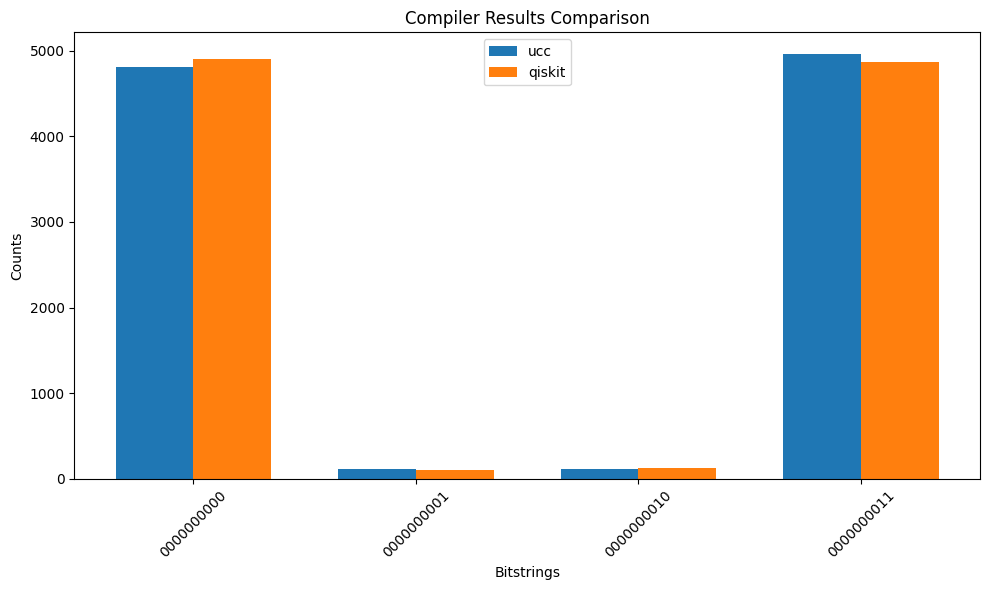

In [11]:
import numpy as np

# Your data
data = results
# Extract binary strings (keys) and sort them
binary_strings = sorted(data[0][1].keys())
compilers = [item[0] for item in data]

# Prepare data for plotting
values = []
for compiler, counts in data:
    values.append([counts[b] for b in binary_strings])

# Set up the plot
x = np.arange(len(binary_strings))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each compiler
for i, (compiler, compiler_values) in enumerate(zip(compilers, values)):
    offset = width * i
    ax.bar(x + offset, compiler_values, width, label=compiler)

# Customize the plot
ax.set_xlabel("Bitstrings")
ax.set_ylabel("Counts")
ax.set_title("Compiler Results Comparison")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(binary_strings, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

### Next steps
Since it appears UCC is doing about on par with Qiskit in this case, we most likely next wish to run our full ucc-bench benchmarks on these devices to compare performance